### Imitation Learning to replace IDM vehicles (represented by a neural network)
- Inputs: 
    - Headway distance (normalized by max headway) to the leader# m
    - Ego Velocity (normalized by max velocity) # m/s
    - Leader Velocity (normalized by max velocity) # m/s

- Output:
    - Acceleration (m/$s^2$). Not manipulated in any way (whatever is present in the data)

- Filtering of data:
    - Since we want to use the IL model at smaller headways. The data contains headways less than 10m only.
    - Whereas for general sampling of data, we use headways upto 150m


In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [2]:
columns = ['direction', 'id', 't', 'x', 'lane_id', 'leader_id', 'headway', 'ego_velocity', 'acceleration']
data = pd.read_csv('./velocity_acceleration_i24.csv', names=columns)
print(data.shape)
data.head()

(274507, 9)


,direction,id,t,x,lane_id,leader_id,headway,ego_velocity,acceleration
0,-1,638c27c03fc03ef13312f609,1.669132e+09,99900.141021,1,638c1aeda5b418cbd77134da,6.397655,NaN,NaN
1,-1,638c27c03fc03ef13312f609,1.669132e+09,99896.108924,1,638c1aeda5b418cbd77134da,6.143910,-33.600839,NaN
2,-1,638c27c03fc03ef13312f609,1.669132e+09,99893.414223,1,638c1aeda5b418cbd77134da,5.986429,-33.683692,-1.035661
3,-1,638c27c03fc03ef13312f609,1.669132e+09,99889.362113,1,638c1aeda5b418cbd77134da,5.767615,-33.767543,-0.698756
4,-1,638c27c03fc03ef13312f609,1.669132e+09,99838.225014,2,638c1aeda5b418cbd77134da,4.833364,-34.552094,-0.530102


In [3]:
data.describe()

,direction,t,x,lane_id,headway,ego_velocity,acceleration
count,274507.000000,2.745070e+05,274507.000000,274507.000000,274507.000000,270012.000000,265609.000000
mean,-0.293752,1.669132e+09,97680.818773,2.384504,70.468396,-9.710411,-0.020250
std,0.955883,2.816139e+02,1474.208145,1.098430,39.722809,29.789955,1.194587
min,-1.000000,1.669132e+09,95604.206146,1.000000,0.002027,-53.319706,-72.448641
25%,-1.000000,1.669132e+09,96264.567429,2.000000,36.400318,-32.811151,-0.341603
50%,-1.000000,1.669132e+09,97406.303538,2.000000,65.748762,-29.264708,-0.008562
75%,1.000000,1.669133e+09,99357.163994,3.000000,102.169226,28.564940,0.308469
max,1.000000,1.669133e+09,100420.280896,5.000000,149.999867,42.000279,77.794739


In [4]:
# Filter headways to be less than 10m. The data points have already been processed so that we can treat them as independent instantaneous values.
data = data[data['headway'] <= 10] 
print(data.shape)
data.head()

(8621, 9)


,direction,id,t,x,lane_id,leader_id,headway,ego_velocity,acceleration
0,-1,638c27c03fc03ef13312f609,1.669132e+09,99900.141021,1,638c1aeda5b418cbd77134da,6.397655,NaN,NaN
1,-1,638c27c03fc03ef13312f609,1.669132e+09,99896.108924,1,638c1aeda5b418cbd77134da,6.143910,-33.600839,NaN
2,-1,638c27c03fc03ef13312f609,1.669132e+09,99893.414223,1,638c1aeda5b418cbd77134da,5.986429,-33.683692,-1.035661
3,-1,638c27c03fc03ef13312f609,1.669132e+09,99889.362113,1,638c1aeda5b418cbd77134da,5.767615,-33.767543,-0.698756
4,-1,638c27c03fc03ef13312f609,1.669132e+09,99838.225014,2,638c1aeda5b418cbd77134da,4.833364,-34.552094,-0.530102


In [5]:
# Create a new column, leader_x which is obtained using headway and x of ego
# If direction = -1, as leader moves forward the x values decrease. So leader_x = x - headway
# If direction = 1, as leader moves forward the x values increase. So leader_x = x + headway 
# print sample direction = 1 values
# print(data[data['direction'] == 1].head())

data['leader_x'] = data['x'] + data['headway'] * data['direction']
# print(data.head())
# print(data[data['direction'] == 1].head())

# Differentiate the leader_x to calculate leader velocity 
def calculate_velocity(df):
    # sort by timesteps 
    df = df.sort_values('t')
    
    # Calculate the time diff as well as x diff 
    df['dt'] = df['t'].diff()
    df['dx'] = df['leader_x'].diff()

    # Calculate velocity as dx/dt
    df['leader_velocity'] = df['dx'] / df['dt']
    
    # drop 
    df.drop(columns=['dt', 'dx'], axis=1, inplace=True)   
    return df

#csv_file_path = './complete_dataset.csv'

# For a current ego vehicle, leader may change so groupby ego_id, leader_id
groups = data.groupby(['id', 'leader_id'])
print(f"Found {len(groups)} groups")

results = [] 
for i, (group_name, group) in enumerate(groups):
    results.append(calculate_velocity(group))

    if i %100==0:
        print(f"Processed {i} groups")
    
    results_df = pd.concat(results)

results_df.head() 

Found 1099 groups
Processed 0 groups
Processed 100 groups
Processed 200 groups
Processed 300 groups
Processed 400 groups
Processed 500 groups
Processed 600 groups
Processed 700 groups
Processed 800 groups
Processed 900 groups
Processed 1000 groups


,direction,id,t,x,lane_id,leader_id,headway,ego_velocity,acceleration,leader_x,leader_velocity
0,-1,638c27c03fc03ef13312f609,1.669132e+09,99900.141021,1,638c1aeda5b418cbd77134da,6.397655,NaN,NaN,99893.743365,NaN
1,-1,638c27c03fc03ef13312f609,1.669132e+09,99896.108924,1,638c1aeda5b418cbd77134da,6.143910,-33.600839,NaN,99889.965014,-31.486291
2,-1,638c27c03fc03ef13312f609,1.669132e+09,99893.414223,1,638c1aeda5b418cbd77134da,5.986429,-33.683692,-1.035661,99887.427794,-31.715189
3,-1,638c27c03fc03ef13312f609,1.669132e+09,99889.362113,1,638c1aeda5b418cbd77134da,5.767615,-33.767543,-0.698756,99883.594499,-31.944092
4,-1,638c27c03fc03ef13312f609,1.669132e+09,99838.225014,2,638c1aeda5b418cbd77134da,4.833364,-34.552094,-0.530102,99833.391650,-33.920843


In [6]:
# From previous processing, the two initial rows are Nan, when differentiation was performed. From new processing some leader_velocity rows are also Nan. Count all Nans
print(results_df.isna().sum())
print(results_df.shape)

# drop all rows with Nan
results_df = results_df.dropna()
print(results_df.shape)

direction             0
id                    0
t                     0
x                     0
lane_id               0
leader_id             0
headway               0
ego_velocity        697
acceleration       1317
leader_x              0
leader_velocity    1099
dtype: int64
(8621, 11)
(6910, 11)


In [7]:
# drop all columns except headway, ego_velocity, leader_velocity, acceleration
selected_df = results_df[['headway', 'ego_velocity', 'leader_velocity', 'acceleration']]

# print the summary statistics of headway, ego_velocity, leader_velocity, acceleration
selected_df.describe()

,headway,ego_velocity,leader_velocity,acceleration
count,6910.000000,6910.000000,6910.000000,6910.000000
mean,4.647384,-11.954613,-11.714342,-0.092933
std,2.767483,27.991567,28.386819,2.065389
min,0.002027,-53.191927,-72.019223,-60.621347
25%,2.283437,-32.262316,-32.177086,-0.465338
50%,4.350237,-28.645815,-26.747491,-0.097148
75%,6.948273,26.100963,24.316397,0.244122
max,9.997851,38.881718,65.557205,77.794739


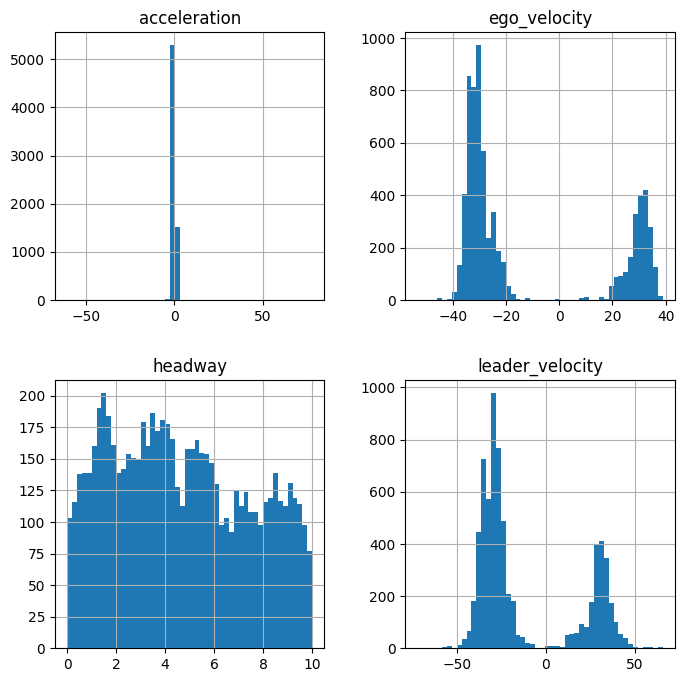

In [8]:
# Plot the histograms of headway, ego_velocity, leader_velocity, acceleration
selected_df.hist(bins=50, figsize=(8,8))
plt.show()

Max among velocities: 65.55720460338432
Max headway: 9.997850971086603


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f182c63c128>,
      dtype=object)

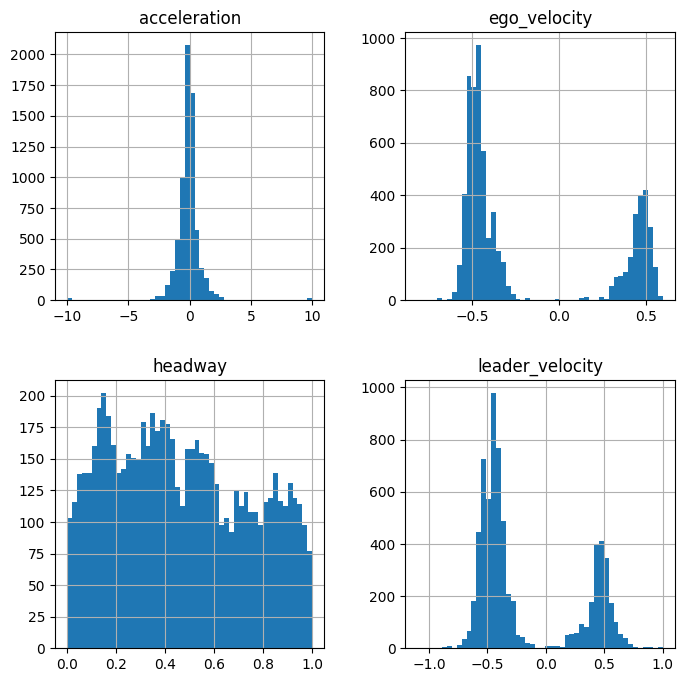

In [9]:
# Normalize velocity with half of  max
max_vel = max(selected_df['ego_velocity'].max(), selected_df['leader_velocity'].max())

print(f"Max among velocities: {max_vel}")
selected_df['ego_velocity'] = selected_df['ego_velocity'] / max_vel
selected_df['leader_velocity'] = selected_df['leader_velocity'] / max_vel

# Normalize the headway with max 
max_headway = selected_df['headway'].max()
print(f"Max headway: {max_headway}")
selected_df['headway'] = selected_df['headway'] / max_headway

# Do not normalize the acceleration. But all acceleration less than -10 are -10 and higher than +10 are +10 
selected_df['acceleration'] = selected_df['acceleration'].clip(-10, 10)

# Plot again 
selected_df.hist(bins=50, figsize=(8,8))

In [10]:
print(selected_df.shape)
selected_df.describe()

(6910, 4)


,headway,ego_velocity,leader_velocity,acceleration
count,6910.000000,6910.000000,6910.000000,6910.000000
mean,0.464838,-0.182354,-0.178689,-0.104200
std,0.276808,0.426979,0.433008,1.108427
min,0.000203,-0.811382,-1.098571,-10.000000
25%,0.228393,-0.492125,-0.490825,-0.465338
50%,0.435117,-0.436959,-0.408002,-0.097148
75%,0.694977,0.398140,0.370919,0.244122
max,1.000000,0.593096,1.000000,10.000000


In [11]:
# Train test split the data
train_df, test_df = train_test_split(selected_df, test_size=0.15, random_state=42)

# Print train and test shapes
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (5873, 4)
Test shape: (1037, 4)


In [12]:
# PT helpers
class CFDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Old
# create a small neural network with 3 layers 
# class NeuralNet(nn.Module):
#     def __init__(self,):
#         super(NeuralNet, self).__init__()
#         self.layer1 = nn.Linear(3, 16)
#         self.layer2 = nn.Linear(16, 8)
#         self.layer3 = nn.Linear(8, 1)
#         #self.relu = nn.ReLU() # ReLU is fine for hidden layers
#         self.tanh = nn.Tanh()
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.tanh(out)
#         out = self.layer2(out)
#         out = self.tanh(out)
#         out = self.layer3(out) # Last layer, no activation
#         return out

# 4 layered NN
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate=0.10): # dropour probability 15%
        super(NeuralNet, self).__init__() 
        self.fc1 = nn.Linear(3, 32)
        self.tanh = nn.Tanh()
        # Adding dropout after the first ReLU
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 16)
        # Adding dropout after the second ReLU
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.dropout1(out)  # Apply dropout here
        
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)  # Apply dropout here
        
        out = self.fc3(out) 
        out = self.tanh(out)
        out = self.fc4(out) # Last layer, no activation
        return out
    

In [13]:
net = NeuralNet()
print(f"Number of parameters: {count_parameters(net)}")

n_epochs = 400 
batch_size = 128

criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.0005)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)  # Added weight_decay for L2 regularization

X_train = train_df[['headway', 'ego_velocity', 'leader_velocity']].values
y_train = train_df['acceleration'].values

train_data = CFDataset(torch.tensor(X_train, dtype = torch.float32) , torch.tensor(y_train, dtype = torch.float32)) 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

X_test = test_df[['headway', 'ego_velocity', 'leader_velocity']].values
y_test = test_df['acceleration'].values

test_data = CFDataset(torch.tensor(X_test, dtype = torch.float32) , torch.tensor(y_test, dtype = torch.float32))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
train_loss_values = []
val_loss_values = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}", end= "\t")

    # Every epoch, train and eval.
    net.train()

    batch_losses = []
    for i, batch in enumerate(train_loader):
        X, y = batch 
        optimizer.zero_grad() # Optimizer is zero grad every batch? Yes
        output = net(X).squeeze()

        #print(f"Output: {output[:5]}")
        #print(f"Target: {y[:5]}")
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses) # Average batch loss per epoch.
    print(f"Train Loss: {round(train_loss,3)}", end="\t")
    train_loss_values.append(train_loss)

    # Eval
    net.eval()
    batch_losses = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            X, y = batch 
            output = net(X).squeeze()
            loss_val = criterion(output, y)
            batch_losses.append(loss_val.item())
        
        val_loss = np.mean(batch_losses) # Average batch loss per validation
        print(f"Val Loss: {round(val_loss,3)}")
        val_loss_values.append(val_loss)

        # If not exists, saved_models, create it
        if not os.path.exists('./saved_models'):
            os.makedirs('./saved_models')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"###### New model saved ######")
            torch.save(net.state_dict(), './saved_models/imitation_best_model.pth')



Number of parameters: 801
Epoch 1/400	Train Loss: 1.241	Val Loss: 1.122
###### New model saved ######
Epoch 2/400	Train Loss: 1.235	Val Loss: 1.121
###### New model saved ######
Epoch 3/400	Train Loss: 1.231	Val Loss: 1.121
Epoch 4/400	Train Loss: 1.231	Val Loss: 1.121
Epoch 5/400	Train Loss: 1.232	Val Loss: 1.122
Epoch 6/400	Train Loss: 1.231	Val Loss: 1.121
Epoch 7/400	Train Loss: 1.233	Val Loss: 1.121
###### New model saved ######
Epoch 8/400	Train Loss: 1.231	Val Loss: 1.122
Epoch 9/400	Train Loss: 1.235	Val Loss: 1.121
Epoch 10/400	Train Loss: 1.231	Val Loss: 1.12
###### New model saved ######
Epoch 11/400	Train Loss: 1.233	Val Loss: 1.121
Epoch 12/400	Train Loss: 1.23	Val Loss: 1.122
Epoch 13/400	Train Loss: 1.23	Val Loss: 1.121
Epoch 14/400	Train Loss: 1.232	Val Loss: 1.121
Epoch 15/400	Train Loss: 1.233	Val Loss: 1.12
###### New model saved ######
Epoch 16/400	Train Loss: 1.23	Val Loss: 1.121
Epoch 17/400	Train Loss: 1.231	Val Loss: 1.12
###### New model saved ######
Epoch 18/4

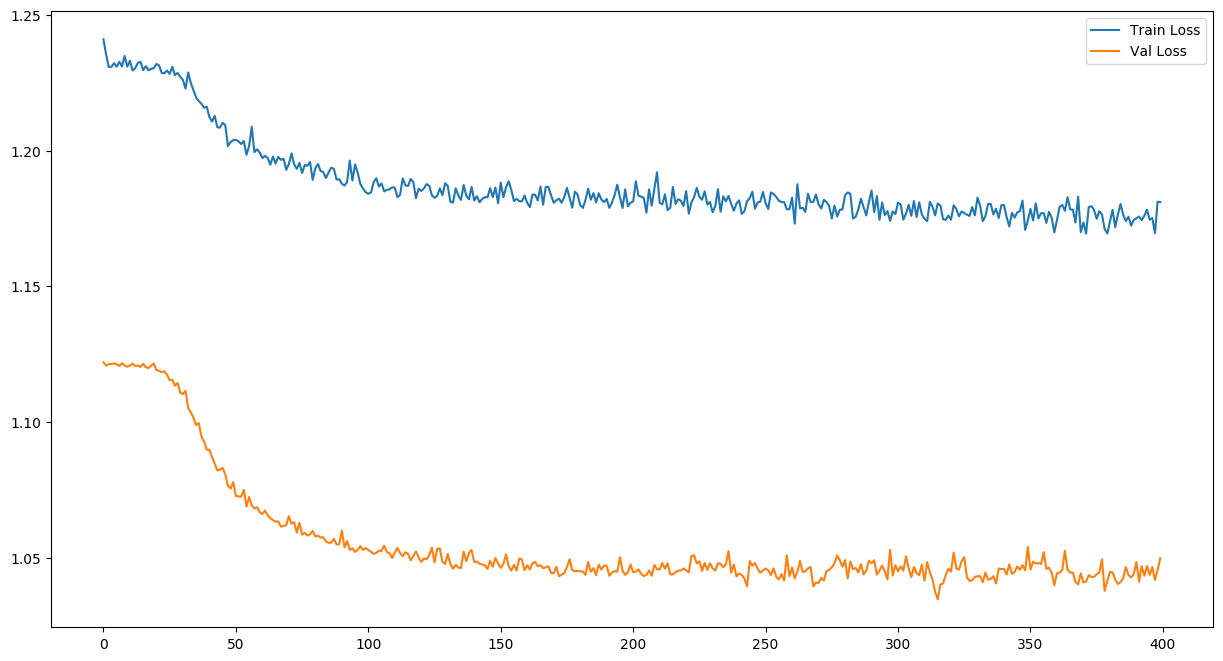

In [14]:
# Plot train and val loss
plt.figure(figsize=(15, 8))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Val Loss')
plt.legend()
plt.show()
